# `causalml` - Meta-Learner Example Notebook
This notebook only contains regression examples.

In [1]:
# pick the right base path (only run ONCE)
import os
base_path = os.path.abspath("../causalml")
os.chdir(base_path)

In [2]:
%reload_ext autoreload
%autoreload 2

In [255]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor, XGBClassifier
import warnings

# from causalml.inference.meta import XGBTLearner, MLPTLearner
from inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from inference.meta import BaseSClassifier, BaseTClassifier, BaseXClassifier, BaseRClassifier
from inference.meta import LRSRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# imports from package
import logging
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import statsmodels.api as sm
from copy import deepcopy

logger = logging.getLogger('causalml')
logging.basicConfig(level=logging.INFO)

%matplotlib inline

# Single Treatment Case

### Generate synthetic data

In [97]:
# Generate synthetic data using mode 1
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=8, sigma=1.0)

treatment = np.array(['treatment_a' if val==1 else 'control' for val in treatment])

## S-Learner

### ATE

In [98]:
learner_s = BaseSRegressor(XGBRegressor(), control_name='control')
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=False)

INFO:causalml:Error metrics for treatment_a
INFO:causalml:RMSE (Control): 0.958908
INFO:causalml: MAE (Control): 0.763500
INFO:causalml:RMSE (Treatment): 0.962411
INFO:causalml: MAE (Treatment): 0.765833


In [99]:
ate_s

array([0.55668548])

In [100]:
learner_s._classes

{'treatment_a': 0}

### ATE w/ Confidence Intervals

In [103]:
alpha = 0.05
learner_s = BaseSRegressor(XGBRegressor(), ate_alpha=alpha, control_name='control')
ate_s, ate_s_lb, ate_s_ub = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=True,
                               n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Error metrics for treatment_a
INFO:causalml:RMSE (Control): 0.958908
INFO:causalml: MAE (Control): 0.763500
INFO:causalml:RMSE (Treatment): 0.962411
INFO:causalml: MAE (Treatment): 0.765833
INFO:causalml:11/100 bootstraps completed. (3s lapsed)
INFO:causalml:21/100 bootstraps completed. (5s lapsed)
INFO:causalml:31/100 bootstraps completed. (8s lapsed)
INFO:causalml:41/100 bootstraps completed. (11s lapsed)
INFO:causalml:51/100 bootstraps completed. (14s lapsed)
INFO:causalml:61/100 bootstraps completed. (17s lapsed)
INFO:causalml:71/100 bootstraps completed. (20s lapsed)
INFO:causalml:81/100 bootstraps completed. (22s lapsed)
INFO:causalml:91/100 bootstraps completed. (25s lapsed)


In [104]:
np.vstack((ate_s_lb, ate_s, ate_s_ub))

array([[0.32128951],
       [0.55668548],
       [0.77378568]])

### CATE

In [105]:
learner_s = BaseSRegressor(XGBRegressor(), control_name='control')
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y, return_ci=False)

INFO:causalml:Error metrics for treatment_a
INFO:causalml:RMSE (Control): 0.958908
INFO:causalml: MAE (Control): 0.763500
INFO:causalml:RMSE (Treatment): 0.962411
INFO:causalml: MAE (Treatment): 0.765833


In [106]:
cate_s

array([[0.03796911],
       [0.69114912],
       [0.05045927],
       ...,
       [0.0114069 ],
       [0.78504539],
       [0.54530191]])

### CATE w/ Confidence Intervals

In [107]:
alpha = 0.05
learner_s = BaseSRegressor(XGBRegressor(), ate_alpha=alpha, control_name='control')
cate_s, cate_s_lb, cate_s_ub = learner_s.fit_predict(X=X, treatment=treatment, y=y, return_ci=True,
                               n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Error metrics for treatment_a
INFO:causalml:RMSE (Control): 0.958908
INFO:causalml: MAE (Control): 0.763500
INFO:causalml:RMSE (Treatment): 0.962411
INFO:causalml: MAE (Treatment): 0.765833
INFO:causalml:11/100 bootstraps completed. (3s lapsed)
INFO:causalml:21/100 bootstraps completed. (5s lapsed)
INFO:causalml:31/100 bootstraps completed. (8s lapsed)
INFO:causalml:41/100 bootstraps completed. (11s lapsed)
INFO:causalml:51/100 bootstraps completed. (14s lapsed)
INFO:causalml:61/100 bootstraps completed. (16s lapsed)
INFO:causalml:71/100 bootstraps completed. (19s lapsed)
INFO:causalml:81/100 bootstraps completed. (22s lapsed)
INFO:causalml:91/100 bootstraps completed. (25s lapsed)


In [108]:
cate_s

array([[0.03796911],
       [0.69114912],
       [0.05045927],
       ...,
       [0.0114069 ],
       [0.78504539],
       [0.54530191]])

In [109]:
cate_s_lb

array([[-0.14735703],
       [ 0.54512397],
       [-0.13866318],
       ...,
       [-0.23455577],
       [ 0.52985432],
       [ 0.27041314]])

In [110]:
cate_s_ub

array([[0.24406555],
       [0.91976507],
       [0.47135236],
       ...,
       [0.45338835],
       [0.88356948],
       [0.8016798 ]])

## T-Learner

### ATE w/ Confidence Intervals

In [111]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='control')
ate_t, ate_t_lb, ate_t_ub = learner_t.estimate_ate(X=X, treatment=treatment, y=y)

INFO:causalml:Error metrics for treatment_a
INFO:causalml:RMSE (Control): 0.929569
INFO:causalml: MAE (Control): 0.739058
INFO:causalml:RMSE (Treatment): 0.927878
INFO:causalml: MAE (Treatment): 0.737494


In [159]:
np.vstack((ate_t_lb, ate_t, ate_t_ub))

array([[0.50665447],
       [0.54399855],
       [0.58134264]])

### CATE

In [115]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='control')
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)

INFO:causalml:Error metrics for treatment_a
INFO:causalml:RMSE (Control): 0.929569
INFO:causalml: MAE (Control): 0.739058
INFO:causalml:RMSE (Treatment): 0.927878
INFO:causalml: MAE (Treatment): 0.737494


In [116]:
cate_t

array([[-0.38664007],
       [ 0.87922645],
       [-0.00171328],
       ...,
       [ 0.43162906],
       [ 0.9598496 ],
       [ 0.50931144]])

### CATE w/ Confidence Intervals

In [117]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='control')
cate_t, cate_t_lb, cate_t_ub = learner_t.fit_predict(X=X, treatment=treatment, y=y, return_ci=True, n_bootstraps=100,
                                                    bootstrap_size=5000)

INFO:causalml:Error metrics for treatment_a
INFO:causalml:RMSE (Control): 0.929569
INFO:causalml: MAE (Control): 0.739058
INFO:causalml:RMSE (Treatment): 0.927878
INFO:causalml: MAE (Treatment): 0.737494
INFO:causalml:10/100 bootstraps completed. (3s lapsed)
INFO:causalml:20/100 bootstraps completed. (6s lapsed)
INFO:causalml:30/100 bootstraps completed. (8s lapsed)
INFO:causalml:40/100 bootstraps completed. (11s lapsed)
INFO:causalml:50/100 bootstraps completed. (14s lapsed)
INFO:causalml:60/100 bootstraps completed. (17s lapsed)
INFO:causalml:70/100 bootstraps completed. (20s lapsed)
INFO:causalml:80/100 bootstraps completed. (23s lapsed)
INFO:causalml:90/100 bootstraps completed. (25s lapsed)


In [119]:
cate_t

array([[-0.38664007],
       [ 0.87922645],
       [-0.00171328],
       ...,
       [ 0.43162906],
       [ 0.9598496 ],
       [ 0.50931144]])

In [120]:
cate_t_lb

array([[-1.10967693],
       [ 0.61126621],
       [-0.74953743],
       ...,
       [-0.79142535],
       [ 0.51201607],
       [-0.5868047 ]])

In [121]:
cate_t_ub

array([[0.15802083],
       [1.22920619],
       [0.58200101],
       ...,
       [1.52186333],
       [1.2845089 ],
       [0.95881709]])

## X-Learner

### ATE w/ Confidence Intervals

In [144]:
learner_x.t_groups

array(['treatment_a'], dtype='<U11')

In [147]:
learner_x = BaseXRegressor(XGBRegressor(), control_name='control')
ate_x, ate_x_lb, ate_x_ub = learner_x.estimate_ate(X=X, p=e, treatment=treatment, y=y)

In [148]:
np.vstack((ate_x_lb, ate_x, ate_x_ub))

array([[0.44068606],
       [0.47768306],
       [0.51468005]])

### CATE

### CATE w/ Confidence Intervals

In [149]:
learner_x = BaseXRegressor(XGBRegressor(), control_name='control')
cate_x, cate_x_lb, cate_x_ub = learner_x.fit_predict(X=X, p=e, treatment=treatment, y=y, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:10/100 bootstraps completed. (5s lapsed)
INFO:causalml:20/100 bootstraps completed. (10s lapsed)
INFO:causalml:30/100 bootstraps completed. (16s lapsed)
INFO:causalml:40/100 bootstraps completed. (21s lapsed)
INFO:causalml:50/100 bootstraps completed. (26s lapsed)
INFO:causalml:60/100 bootstraps completed. (31s lapsed)
INFO:causalml:70/100 bootstraps completed. (36s lapsed)
INFO:causalml:80/100 bootstraps completed. (42s lapsed)
INFO:causalml:90/100 bootstraps completed. (47s lapsed)


In [150]:
cate_x

array([[-0.26100034],
       [ 0.71815765],
       [ 0.00939685],
       ...,
       [-0.3770929 ],
       [ 0.4899036 ],
       [ 0.21823683]])

In [151]:
cate_x_lb

array([[-0.92892738],
       [ 0.3496155 ],
       [-0.53877904],
       ...,
       [-0.7457863 ],
       [ 0.28050901],
       [-0.32397448]])

In [152]:
cate_x_ub

array([[0.10388473],
       [1.00357826],
       [0.55702635],
       ...,
       [0.25875652],
       [0.83988882],
       [0.6069184 ]])

## R-Learner

### ATE w/ Confidence Intervals

In [154]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
ate_r, ate_r_lb, ate_r_ub = learner_r.estimate_ate(X=X, p=e, treatment=treatment, y=y)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss


In [158]:
np.vstack((ate_r_lb, ate_r, ate_r_ub))

array([[0.45737808],
       [0.45778109],
       [0.4581841 ]])

### CATE

In [160]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
cate_r = learner_r.fit_predict(X=X, p=e, treatment=treatment, y=y)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss


In [161]:
cate_r

array([[-0.33700937],
       [ 0.82450795],
       [ 0.16467026],
       ...,
       [ 0.2166025 ],
       [ 0.45501849],
       [ 0.32438049]])

### CATE w/ Confidence Intervals

In [167]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
cate_r, cate_r_lb, cate_r_ub = learner_r.fit_predict(X=X, p=e, treatment=treatment, y=y, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=3000)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:10/100 bootstraps completed. (7s lapsed)
INFO:causalml:20/100 bootstraps completed. (14s lapsed)
INFO:causalml:30/100 bootstraps completed. (21s lapsed)
INFO:causalml:40/100 bootstraps completed. (28s lapsed)
INFO:causalml:50/100 bootstraps completed. (35s lapsed)
INFO:causalml:60/100 bootstraps completed. (41s lapsed)
INFO:causalml:70/100 bootstraps completed. (48s lapsed)
INFO:causalml:80/100 bootstraps completed. (55s lapsed)
INFO:causalml:90/100 bootstraps completed. (62s lapsed)


In [168]:
cate_r

array([[-0.37464064],
       [ 0.82177085],
       [ 0.20239475],
       ...,
       [ 0.18415594],
       [ 0.48149735],
       [ 0.25537789]])

In [169]:
cate_r_lb

array([[-0.9802328 ],
       [ 0.13664687],
       [-1.3368755 ],
       ...,
       [-0.97330393],
       [-0.00957918],
       [-0.7125189 ]])

In [170]:
cate_r_ub

array([[0.64070718],
       [1.25403838],
       [1.06775643],
       ...,
       [1.43190208],
       [0.95540813],
       [0.87571691]])

# Multiple Treatment Case

### Generate synthetic data
Note: we randomize the assignment of treatment flag AFTER the synthetic data generation process, so it doesn't make sense to measure accuracy metrics here. Next steps would be to include multi-treatment in the DGP itself.

In [171]:
# Generate synthetic data using mode 1
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=8, sigma=1.0)

treatment = np.array([('treatment_a' if np.random.random() > 0.2 else 'treatment_b') 
                      if val==1 else 'control' for val in treatment])

e = {group: e for group in np.unique(treatment)}

In [173]:
pd.Series(treatment).value_counts()

control        4820
treatment_a    4110
treatment_b    1070
dtype: int64

## S-Learner

### ATE

In [174]:
learner_s = BaseSRegressor(XGBRegressor(), control_name='control')
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=False)

INFO:causalml:Error metrics for treatment_a
INFO:causalml:RMSE (Control): 0.991463
INFO:causalml: MAE (Control): 0.787094
INFO:causalml:RMSE (Treatment): 0.970982
INFO:causalml: MAE (Treatment): 0.774108
INFO:causalml:Error metrics for treatment_b
INFO:causalml:RMSE (Control): 0.998294
INFO:causalml: MAE (Control): 0.794750
INFO:causalml:RMSE (Treatment): 0.919352
INFO:causalml: MAE (Treatment): 0.733635


In [175]:
ate_s

array([0.35913358, 0.18256349])

In [176]:
learner_s._classes

{'treatment_a': 0, 'treatment_b': 1}

### ATE w/ Confidence Intervals
Note: S-Learner is the only learner that uses bootstrapping to get confidence intervals.

In [178]:
alpha = 0.05
learner_s = BaseSRegressor(XGBRegressor(), ate_alpha=alpha, control_name='control')
ate_s, ate_s_lb, ate_s_ub = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=True,
                               n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Error metrics for treatment_a
INFO:causalml:RMSE (Control): 0.991463
INFO:causalml: MAE (Control): 0.787094
INFO:causalml:RMSE (Treatment): 0.970982
INFO:causalml: MAE (Treatment): 0.774108
INFO:causalml:Error metrics for treatment_b
INFO:causalml:RMSE (Control): 0.998294
INFO:causalml: MAE (Control): 0.794750
INFO:causalml:RMSE (Treatment): 0.919352
INFO:causalml: MAE (Treatment): 0.733635
INFO:causalml:11/100 bootstraps completed. (6s lapsed)
INFO:causalml:21/100 bootstraps completed. (11s lapsed)
INFO:causalml:31/100 bootstraps completed. (16s lapsed)
INFO:causalml:41/100 bootstraps completed. (22s lapsed)
INFO:causalml:51/100 bootstraps completed. (27s lapsed)
INFO:causalml:61/100 bootstraps completed. (33s lapsed)
INFO:causalml:71/100 bootstraps completed. (38s lapsed)
INFO:causalml:81/100 bootstraps completed. (44s lapsed)
INFO:causalml:91/100 bootstraps completed. (49s lapsed)


In [179]:
np.vstack((ate_s_lb, ate_s, ate_s_ub))

array([[ 0.14345376, -0.03237222],
       [ 0.35913358,  0.18256349],
       [ 0.5507962 ,  0.37659037]])

### CATE

In [180]:
learner_s = BaseSRegressor(XGBRegressor(), control_name='control')
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y, return_ci=False)

INFO:causalml:Error metrics for treatment_a
INFO:causalml:RMSE (Control): 0.991463
INFO:causalml: MAE (Control): 0.787094
INFO:causalml:RMSE (Treatment): 0.970982
INFO:causalml: MAE (Treatment): 0.774108
INFO:causalml:Error metrics for treatment_b
INFO:causalml:RMSE (Control): 0.998294
INFO:causalml: MAE (Control): 0.794750
INFO:causalml:RMSE (Treatment): 0.919352
INFO:causalml: MAE (Treatment): 0.733635


In [181]:
cate_s

array([[0.29305696, 0.20715189],
       [0.2394737 , 0.23082519],
       [0.45016623, 0.13159585],
       ...,
       [0.44311321, 0.15472066],
       [0.39511681, 0.15956807],
       [0.22280121, 0.14637351]])

### CATE w/ Confidence Intervals

In [182]:
alpha = 0.05
learner_s = BaseSRegressor(XGBRegressor(), ate_alpha=alpha, control_name='control')
cate_s, cate_s_lb, cate_s_ub = learner_s.fit_predict(X=X, treatment=treatment, y=y, return_ci=True,
                               n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Error metrics for treatment_a
INFO:causalml:RMSE (Control): 0.991463
INFO:causalml: MAE (Control): 0.787094
INFO:causalml:RMSE (Treatment): 0.970982
INFO:causalml: MAE (Treatment): 0.774108
INFO:causalml:Error metrics for treatment_b
INFO:causalml:RMSE (Control): 0.998294
INFO:causalml: MAE (Control): 0.794750
INFO:causalml:RMSE (Treatment): 0.919352
INFO:causalml: MAE (Treatment): 0.733635
INFO:causalml:11/100 bootstraps completed. (6s lapsed)
INFO:causalml:21/100 bootstraps completed. (11s lapsed)
INFO:causalml:31/100 bootstraps completed. (17s lapsed)
INFO:causalml:41/100 bootstraps completed. (22s lapsed)
INFO:causalml:51/100 bootstraps completed. (28s lapsed)
INFO:causalml:61/100 bootstraps completed. (33s lapsed)
INFO:causalml:71/100 bootstraps completed. (39s lapsed)
INFO:causalml:81/100 bootstraps completed. (44s lapsed)
INFO:causalml:91/100 bootstraps completed. (49s lapsed)


In [183]:
cate_s

array([[0.29305696, 0.20715189],
       [0.2394737 , 0.23082519],
       [0.45016623, 0.13159585],
       ...,
       [0.44311321, 0.15472066],
       [0.39511681, 0.15956807],
       [0.22280121, 0.14637351]])

In [184]:
cate_s_lb

array([[-0.04259078,  0.03480431],
       [-0.05326713,  0.048358  ],
       [ 0.27760496, -0.06061491],
       ...,
       [ 0.28635021,  0.02252018],
       [ 0.19727507, -0.03052257],
       [ 0.07766245, -0.01838151]])

In [185]:
cate_s_ub

array([[0.44047487, 0.33187835],
       [0.45214516, 0.34100947],
       [0.61380313, 0.31094917],
       ...,
       [0.60039392, 0.33422943],
       [0.61935563, 0.25369784],
       [0.52657488, 0.42135347]])

## T-Learner

### ATE w/ Confidence Intervals

In [186]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='control')
ate_t, ate_t_lb, ate_t_ub = learner_t.estimate_ate(X=X, treatment=treatment, y=y)

INFO:causalml:Error metrics for treatment_a
INFO:causalml:RMSE (Control): 0.971329
INFO:causalml: MAE (Control): 0.769895
INFO:causalml:RMSE (Treatment): 0.934618
INFO:causalml: MAE (Treatment): 0.743548
INFO:causalml:Error metrics for treatment_b
INFO:causalml:RMSE (Control): 0.993107
INFO:causalml: MAE (Control): 0.789818
INFO:causalml:RMSE (Treatment): 0.796908
INFO:causalml: MAE (Treatment): 0.628517


In [187]:
np.vstack((ate_t_lb, ate_t, ate_t_ub))

array([[0.32926924, 0.19934954],
       [0.36743379, 0.25176689],
       [0.40559833, 0.30418423]])

### CATE

In [188]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='control')
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)

INFO:causalml:Error metrics for treatment_a
INFO:causalml:RMSE (Control): 0.971329
INFO:causalml: MAE (Control): 0.769895
INFO:causalml:RMSE (Treatment): 0.934618
INFO:causalml: MAE (Treatment): 0.743548
INFO:causalml:Error metrics for treatment_b
INFO:causalml:RMSE (Control): 0.993107
INFO:causalml: MAE (Control): 0.789818
INFO:causalml:RMSE (Treatment): 0.796908
INFO:causalml: MAE (Treatment): 0.628517


In [189]:
cate_t

array([[ 0.28441787,  0.38072431],
       [ 0.56165069,  0.65201128],
       [ 0.54719591, -0.18444657],
       ...,
       [ 0.44603789,  0.04932952],
       [ 0.61214852, -0.05190253],
       [ 0.38557649,  0.68061471]])

### CATE w/ Confidence Intervals

In [190]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='control')
cate_t, cate_t_lb, cate_t_ub = learner_t.fit_predict(X=X, treatment=treatment, y=y, return_ci=True, n_bootstraps=100,
                                                    bootstrap_size=5000)

INFO:causalml:Error metrics for treatment_a
INFO:causalml:RMSE (Control): 0.971329
INFO:causalml: MAE (Control): 0.769895
INFO:causalml:RMSE (Treatment): 0.934618
INFO:causalml: MAE (Treatment): 0.743548
INFO:causalml:Error metrics for treatment_b
INFO:causalml:RMSE (Control): 0.993107
INFO:causalml: MAE (Control): 0.789818
INFO:causalml:RMSE (Treatment): 0.796908
INFO:causalml: MAE (Treatment): 0.628517
INFO:causalml:10/100 bootstraps completed. (6s lapsed)
INFO:causalml:20/100 bootstraps completed. (12s lapsed)
INFO:causalml:30/100 bootstraps completed. (17s lapsed)
INFO:causalml:40/100 bootstraps completed. (23s lapsed)
INFO:causalml:50/100 bootstraps completed. (28s lapsed)
INFO:causalml:60/100 bootstraps completed. (34s lapsed)
INFO:causalml:70/100 bootstraps completed. (40s lapsed)
INFO:causalml:80/100 bootstraps completed. (45s lapsed)
INFO:causalml:90/100 bootstraps completed. (51s lapsed)


In [191]:
cate_t

array([[ 0.28441787,  0.38072431],
       [ 0.56165069,  0.65201128],
       [ 0.54719591, -0.18444657],
       ...,
       [ 0.44603789,  0.04932952],
       [ 0.61214852, -0.05190253],
       [ 0.38557649,  0.68061471]])

In [192]:
cate_t_lb

array([[-0.04115869, -0.05224179],
       [-0.16902418, -0.19706225],
       [-0.00189665, -0.8080983 ],
       ...,
       [ 0.10415745, -0.23481247],
       [ 0.15116205, -0.78067239],
       [-0.46228578, -0.81511819]])

In [193]:
cate_t_ub

array([[0.74080166, 1.06598807],
       [0.79825233, 0.8707759 ],
       [1.34376909, 0.64097773],
       ...,
       [0.75215713, 0.51593655],
       [1.03536093, 0.43499326],
       [1.04148687, 1.6343584 ]])

## X-Learner

### ATE w/ Confidence Intervals

In [194]:
learner_x = BaseXRegressor(XGBRegressor(), control_name='control')
ate_x, ate_x_lb, ate_x_ub = learner_x.estimate_ate(X=X, p=e, treatment=treatment, y=y)

In [195]:
np.vstack((ate_x_lb, ate_x, ate_x_ub))

array([[0.31400111, 0.19998552],
       [0.35198314, 0.25217314],
       [0.38996516, 0.30436076]])

### CATE

In [196]:
learner_x = BaseXRegressor(XGBRegressor(), control_name='control')
cate_x = learner_x.fit_predict(X=X, p=e, treatment=treatment, y=y)

In [197]:
cate_x

array([[ 0.26990545,  0.26035661],
       [ 0.26034176,  0.46985847],
       [ 0.37140876, -0.04080141],
       ...,
       [ 0.43502373,  0.22133699],
       [ 0.42731443, -0.0570209 ],
       [ 0.46857533,  0.35744303]])

### CATE w/ Confidence Intervals

In [198]:
learner_x = BaseXRegressor(XGBRegressor(), control_name='control')
cate_x, cate_x_lb, cate_x_ub = learner_x.fit_predict(X=X, p=e, treatment=treatment, y=y, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:10/100 bootstraps completed. (10s lapsed)
INFO:causalml:20/100 bootstraps completed. (20s lapsed)
INFO:causalml:30/100 bootstraps completed. (31s lapsed)
INFO:causalml:40/100 bootstraps completed. (41s lapsed)
INFO:causalml:50/100 bootstraps completed. (51s lapsed)
INFO:causalml:60/100 bootstraps completed. (61s lapsed)
INFO:causalml:70/100 bootstraps completed. (71s lapsed)
INFO:causalml:80/100 bootstraps completed. (81s lapsed)
INFO:causalml:90/100 bootstraps completed. (91s lapsed)


In [199]:
learner_x._classes

{'treatment_a': 0, 'treatment_b': 1}

In [200]:
cate_x

array([[ 0.26990545,  0.26035661],
       [ 0.26034176,  0.46985847],
       [ 0.37140876, -0.04080141],
       ...,
       [ 0.43502373,  0.22133699],
       [ 0.42731443, -0.0570209 ],
       [ 0.46857533,  0.35744303]])

In [201]:
cate_x_lb

array([[ 0.02105564, -0.00483451],
       [ 0.05179861,  0.09180887],
       [ 0.12221365, -0.44646286],
       ...,
       [ 0.25909399, -0.02073404],
       [ 0.14467462, -0.32544759],
       [-0.08245101, -0.32453551]])

In [202]:
cate_x_ub

array([[0.48926775, 0.61125675],
       [0.60614869, 0.71524641],
       [0.96047391, 0.43098129],
       ...,
       [0.67855977, 0.40955369],
       [0.63019724, 0.34458099],
       [0.98388902, 0.98262639]])

## R-Learner

### ATE w/ Confidence Intervals

In [203]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
ate_r, ate_r_lb, ate_r_ub = learner_r.estimate_ate(X=X, p=e, treatment=treatment, y=y)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss


In [204]:
np.vstack((ate_r_lb, ate_r, ate_r_ub))

array([[0.28862501, 0.10444676],
       [0.2890347 , 0.10506716],
       [0.28944439, 0.10568755]])

### CATE

In [205]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
cate_r = learner_r.fit_predict(X=X, p=e, treatment=treatment, y=y)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss


In [206]:
cate_r

array([[ 0.15946019,  0.0566867 ],
       [ 0.26207751,  0.08914298],
       [ 0.35971397, -0.11964369],
       ...,
       [ 0.28634119, -0.05715203],
       [ 0.33082661, -0.08944744],
       [ 0.22354212,  0.29110223]])

### CATE w/ Confidence Intervals

In [207]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
cate_r, cate_r_lb, cate_r_ub = learner_r.fit_predict(X=X, p=e, treatment=treatment, y=y, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=3000)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss
INFO:causalml:10/100 bootstraps completed. (8s lapsed)
INFO:causalml:20/100 bootstraps completed. (16s lapsed)
INFO:causalml:30/100 bootstraps completed. (25s lapsed)
INFO:causalml:40/100 bootstraps completed. (33s lapsed)
INFO:causalml:50/100 bootstraps completed. (42s lapsed)
INFO:causalml:60/100 bootstraps completed. (50s lapsed)
INFO:causalml:70/100 bootstraps completed. (58s lapsed)
INFO:causalml:80/100 bootstraps completed. (66s lapsed)
INFO:causalml:90/100 bootstraps completed. (74s lapsed)


In [208]:
cate_r

array([[ 0.09944364,  0.04709589],
       [ 0.25123295,  0.08984098],
       [ 0.36286271, -0.14600784],
       ...,
       [ 0.34693044, -0.04801428],
       [ 0.32974464, -0.1315679 ],
       [ 0.2060248 ,  0.16616488]])

In [209]:
cate_r_lb

array([[-0.34995239, -0.19428928],
       [-0.23480286, -0.33930292],
       [-0.08365641, -0.61383729],
       ...,
       [-0.0510494 , -0.20574036],
       [-0.01827118, -0.37462993],
       [-0.60967366, -0.25259556]])

In [210]:
cate_r_ub

array([[0.59212104, 0.51029717],
       [0.74375887, 0.48526926],
       [1.17339422, 0.11729919],
       ...,
       [0.8433193 , 0.18996149],
       [0.80591545, 0.37860441],
       [1.47198277, 0.90086589]])

# Visualize

In [212]:
groups

{'treatment_a': 0, 'treatment_b': 1}

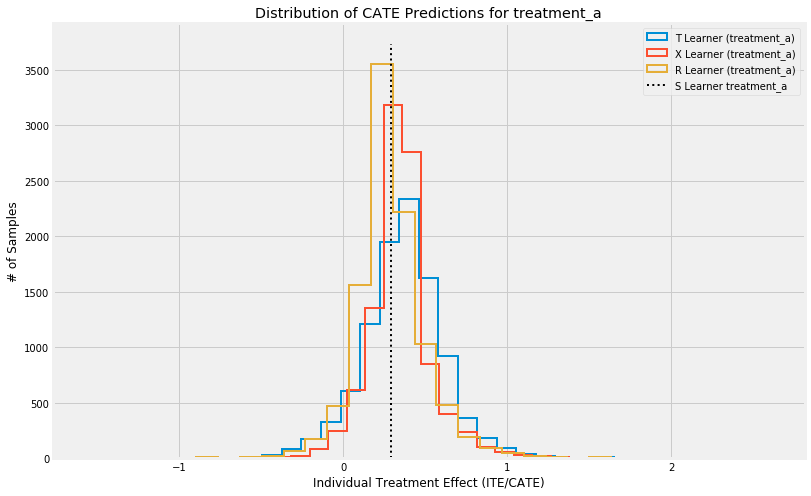

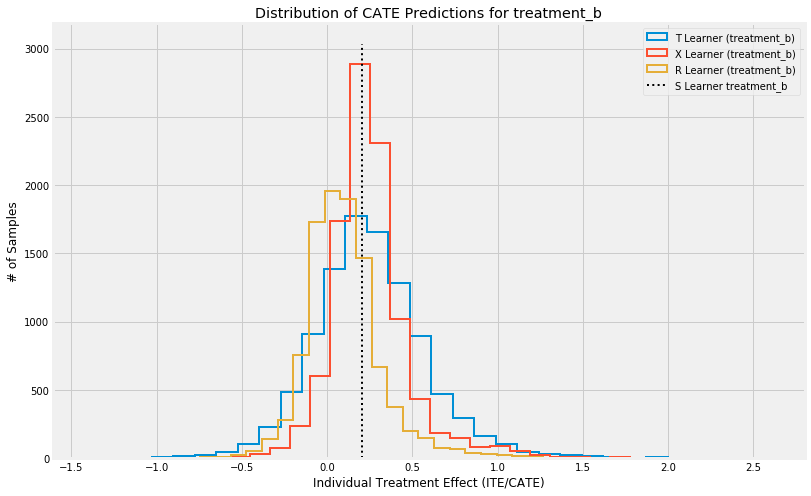

In [214]:
groups = learner_r._classes

alpha = 1
linewidth = 2
bins = 30
for group,idx in sorted(groups.items(), key=lambda x: x[1]):
    plt.figure(figsize=(12,8))
    plt.hist(cate_t[:,idx], alpha=alpha, bins=bins, label='T Learner ({})'.format(group),
             histtype='step', linewidth=linewidth)
    plt.hist(cate_x[:,idx], alpha=alpha, bins=bins, label='X Learner ({})'.format(group),
             histtype='step', linewidth=linewidth)
    plt.hist(cate_r[:,idx], alpha=alpha, bins=bins, label='R Learner ({})'.format(group),
             histtype='step', linewidth=linewidth)
    plt.vlines(cate_s[0,idx], 0, plt.axes().get_ylim()[1], label='S Learner ({})'.format(group),
               linestyles='dotted', linewidth=linewidth)
    plt.title('Distribution of CATE Predictions for {}'.format(group))
    plt.xlabel('Individual Treatment Effect (ITE/CATE)')
    plt.ylabel('# of Samples')
    _=plt.legend()